<a href="https://colab.research.google.com/github/donghuna/AI_Expert_Lecture_Files/blob/main/Lab3_1_cGAN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import PIL

### Generative Adversarial Networks
#### Generator
- Generates fake images
- Get labels to generates specific images

In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size

        self.gen_fc1 = nn.Linear(self.latent_size, 128)
        self.label_fc = nn.Linear(10, 128)
        self.gen_fc2 = nn.Linear(256, 512)
        self.gen_fc3 = nn.Linear(512, 784)

    def generator(self, label):
        batch_size = label.shape[0] # 첫번재 dim 값이 배치 크기이다
        z = torch.randn((batch_size, self.latent_size)) # 정규 분포에서 샘플링된 batch_size x latent_size 크기의 잠재 벡터
        if torch.cuda.is_available():
            z = z.cuda()

        gen = self.gen_fc1(z)
        gen_label = self.label_fc(label)

        # 마지막 축을 기준으로 텐서를 결합
        # gen: (batch_size, 128), gen_label: (batch_size, 128) = result: (batch_size, 256)
        gen = torch.cat((gen, gen_label), -1)

        gen = torch.relu(gen)
        gen = self.gen_fc2(gen)
        gen = torch.relu(gen)
        gen = self.gen_fc3(gen)
        img_ = torch.sigmoid(gen).view(-1,1,28,28)
        return img_

    def forward(self,label):
        img = self.generator(label)
        return img

#### Discriminator
- Find fake images

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.dis_fc1 = nn.Linear(784,512)
        self.dis_fc2 = nn.Linear(512,128)
        self.label_fc = nn.Linear(10,128)
        self.dis_fc3 = nn.Linear(256,32)
        self.dis_fc4 = nn.Linear(32,1)

    def discriminator(self,img,label):
        batch_size = img.shape[0]
        img = img.view(batch_size,-1)

        dis = self.dis_fc1(img)
        dis = torch.relu(dis)
        dis = self.dis_fc2(dis)
        dis = torch.relu(dis)
        dis_label = self.label_fc(label)
        dis = torch.cat((dis,dis_label),-1)
        dis = self.dis_fc3(dis)
        dis = torch.relu(dis)
        dis = self.dis_fc4(dis)
        dis = torch.sigmoid(dis)
        return dis

    def forward(self,img,label):
        criterion = self.discriminator(img,label)
        return criterion

#### Util functions

In [ ]:
def one_hot(x):
    res = torch.zeros((x.shape[0],10))
    for i in range(x.shape[0]):
        res[i,x[i]]=1
    return res

#### Hyperparameters

In [ ]:
NUM_EPOCHS = 150
BATCH_SIZE = 128
LATENT_SIZE = 100
LEARNING_RATE = 2e-4
EPS = 1e-6
LEARNING_RATIO = 1

#### Dataloader

In [ ]:
transforms = Compose([
    ToTensor(),
])

trainset = MNIST('./',train=True,transform=transforms,download=True)
testset = MNIST('./',train=False,transform=transforms,download=True)

args = {
    'num_workers' : 1,
    'batch_size' : BATCH_SIZE,
    'shuffle' : True,
}

train_loader = DataLoader(trainset,**args)
test_loader = DataLoader(testset,**args)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4427079.32it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 55962.19it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 841296.20it/s] 


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4972730.04it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



#### Training part

number of parameters(generator) : 548112
number of parameters(discriminator) : 477249
epoch 1
 gen : 1788.99501	 dis : 160.97157


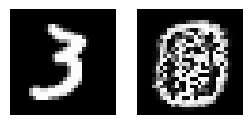

epoch 2
 gen : 2569.75464	 dis : 31.69597


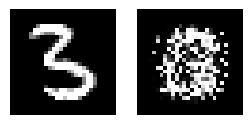

epoch 3
 gen : 2535.55756	 dis : 31.86068


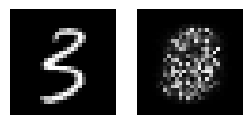

epoch 4
 gen : 2481.97922	 dis : 28.60800


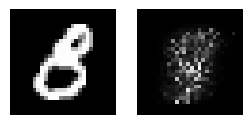

epoch 5
 gen : 2994.56627	 dis : 14.24215


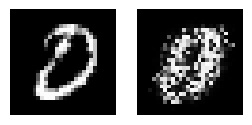

epoch 6
 gen : 3729.75342	 dis : 8.35484


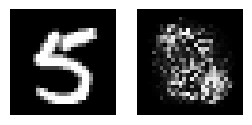

epoch 7
 gen : 4144.53688	 dis : 7.32647


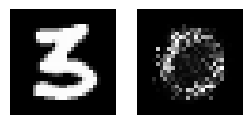

epoch 8
 gen : 4387.28072	 dis : 11.13536


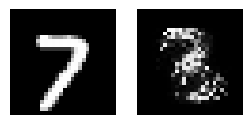

epoch 9
 gen : 4490.54991	 dis : 11.66528


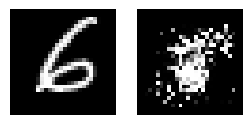

epoch 10
 gen : 4754.19678	 dis : 7.78735


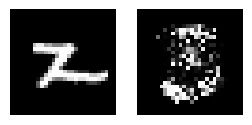

epoch 11
 gen : 3869.25786	 dis : 17.85102


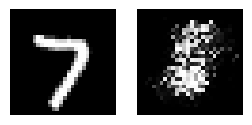

epoch 12
 gen : 3882.13977	 dis : 12.84297


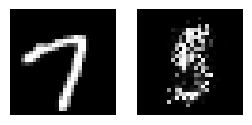

epoch 13
 gen : 4183.86187	 dis : 11.27139


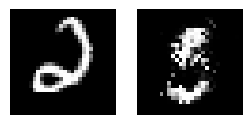

epoch 14
 gen : 3995.81781	 dis : 13.22726


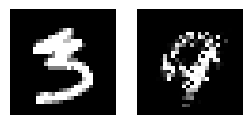

epoch 15
 gen : 4245.58492	 dis : 11.44518


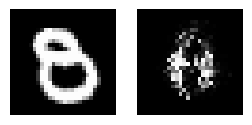

epoch 16
 gen : 3951.85333	 dis : 16.70879


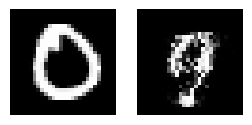

epoch 17
 gen : 4225.74500	 dis : 15.70405


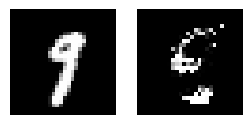

epoch 18
 gen : 4288.10340	 dis : 20.72115


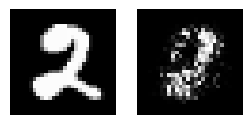

epoch 19
 gen : 3970.66702	 dis : 23.37390


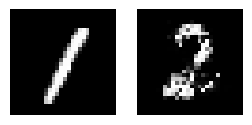

epoch 20
 gen : 3493.85099	 dis : 31.32582


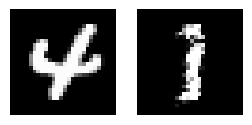

epoch 21
 gen : 3343.43936	 dis : 34.36607


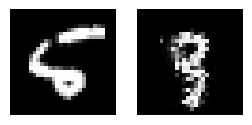

epoch 22
 gen : 3026.74795	 dis : 37.20076


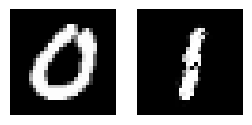

epoch 23
 gen : 3022.81875	 dis : 35.65409


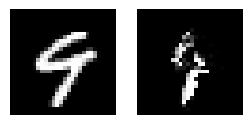

epoch 24
 gen : 2971.01776	 dis : 43.53755


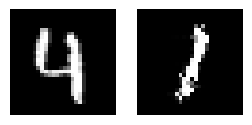

epoch 25
 gen : 2855.80627	 dis : 50.42098


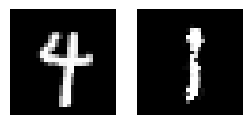

epoch 26
 gen : 2738.18115	 dis : 56.44521


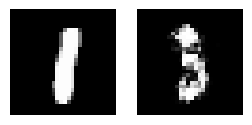

epoch 27
 gen : 2747.03456	 dis : 58.66530


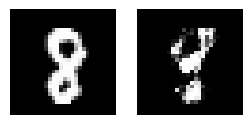

epoch 28
 gen : 2553.81144	 dis : 75.93043


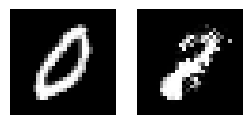

epoch 29
 gen : 2440.63800	 dis : 81.96572


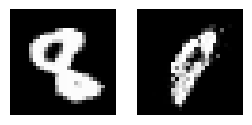

epoch 30
 gen : 2386.65033	 dis : 88.12925


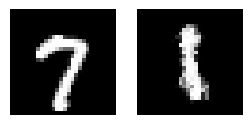

epoch 31
 gen : 2330.51494	 dis : 88.32819


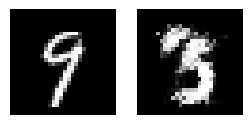

epoch 32
 gen : 2341.53097	 dis : 90.71850


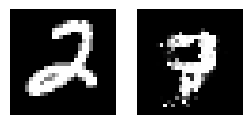

epoch 33
 gen : 2298.25654	 dis : 96.15556


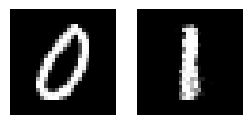

epoch 34
 gen : 2264.69760	 dis : 101.38040


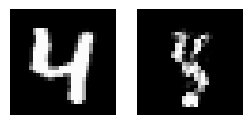

epoch 35
 gen : 2218.55072	 dis : 111.21583


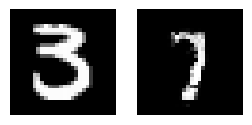

epoch 36
 gen : 2226.39364	 dis : 105.56630


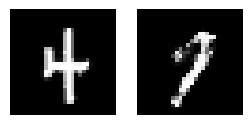

epoch 37
 gen : 2156.55050	 dis : 115.28613


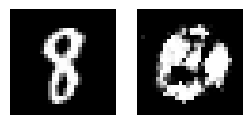

epoch 38
 gen : 2203.20783	 dis : 112.96357


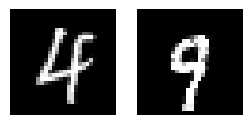

epoch 39
 gen : 2190.24612	 dis : 118.32171


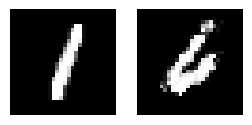

epoch 40
 gen : 2249.23202	 dis : 113.47714


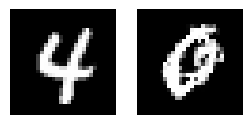

epoch 41
 gen : 2267.58152	 dis : 112.32384


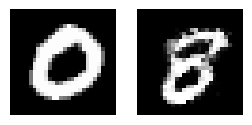

epoch 42
 gen : 2307.96595	 dis : 108.82546


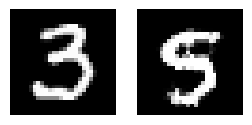

epoch 43
 gen : 2378.88929	 dis : 111.52461


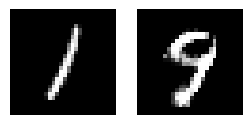

epoch 44
 gen : 2456.09760	 dis : 108.92707


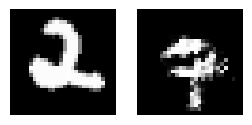

epoch 45
 gen : 2505.86109	 dis : 107.76193


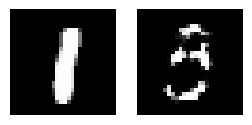

epoch 46
 gen : 2547.54936	 dis : 106.13287


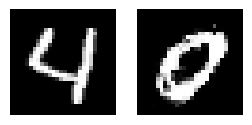

epoch 47
 gen : 2617.73295	 dis : 103.12371


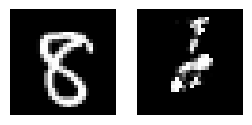

epoch 48
 gen : 2679.62702	 dis : 99.47305


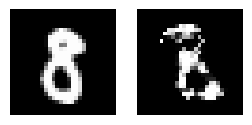

epoch 49
 gen : 2719.32464	 dis : 98.29013


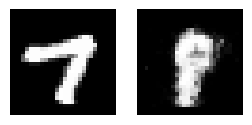

epoch 50
 gen : 2746.23300	 dis : 97.52298


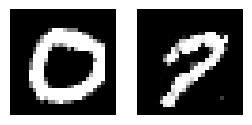

epoch 51
 gen : 2810.48913	 dis : 92.05114


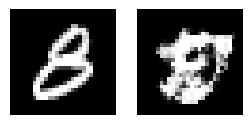

epoch 52
 gen : 2889.38451	 dis : 91.78724


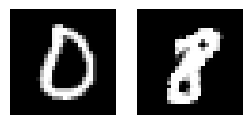

epoch 53
 gen : 2906.22308	 dis : 89.68631


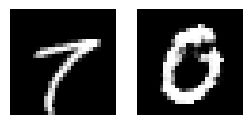

epoch 54
 gen : 2941.21303	 dis : 87.29613


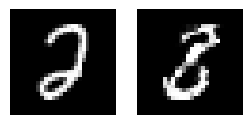

epoch 55
 gen : 2971.02904	 dis : 87.30659


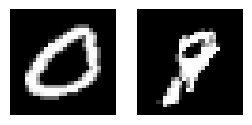

epoch 56
 gen : 3014.93704	 dis : 85.34278


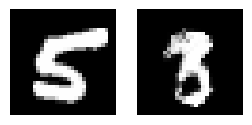

epoch 57
 gen : 3050.52741	 dis : 83.64966


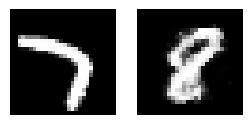

epoch 58
 gen : 3091.03826	 dis : 82.09746


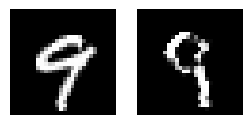

epoch 59
 gen : 3126.95990	 dis : 80.57943


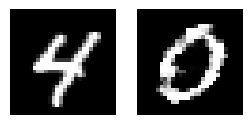

epoch 60
 gen : 3165.35733	 dis : 80.02740


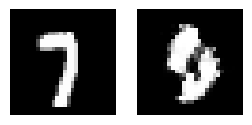

epoch 61
 gen : 3197.75211	 dis : 77.47460


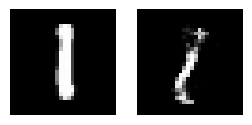

epoch 62
 gen : 3293.35090	 dis : 72.92032


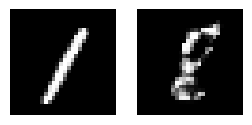

epoch 63
 gen : 3302.33544	 dis : 71.13304


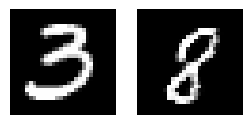

epoch 64
 gen : 3363.09363	 dis : 69.03494


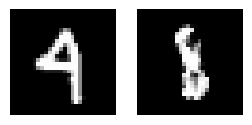

epoch 65
 gen : 3410.11775	 dis : 70.48855


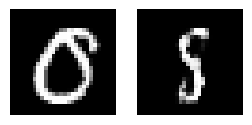

epoch 66
 gen : 3465.82761	 dis : 68.24481


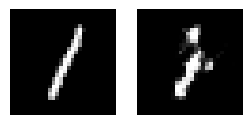

epoch 67
 gen : 3505.41365	 dis : 65.36078


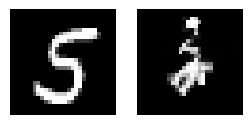

epoch 68
 gen : 3547.12889	 dis : 62.07378


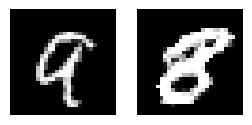

epoch 69
 gen : 3605.98895	 dis : 61.85678


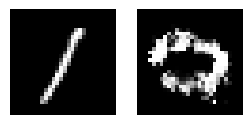

epoch 70
 gen : 3638.50069	 dis : 60.86595


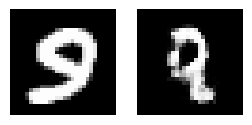

epoch 71
 gen : 3668.86540	 dis : 62.60861


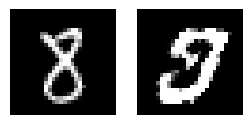

epoch 72
 gen : 3699.27422	 dis : 59.81378


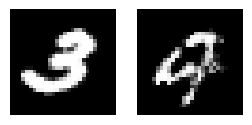

epoch 73
 gen : 3754.84871	 dis : 59.42016


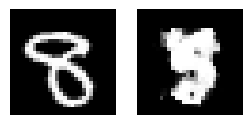

epoch 74
 gen : 3748.89545	 dis : 58.47965


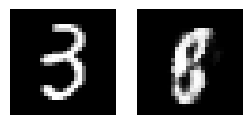

epoch 75
 gen : 3805.93393	 dis : 56.17488


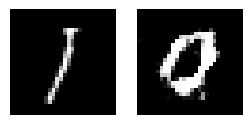

epoch 76
 gen : 3830.09369	 dis : 57.59752


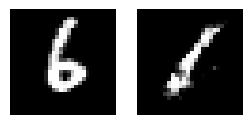

epoch 77
 gen : 3879.40094	 dis : 55.97809


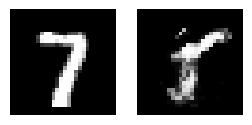

epoch 78
 gen : 3895.49678	 dis : 55.75697


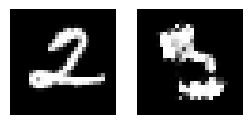

epoch 79
 gen : 3961.79706	 dis : 55.18054


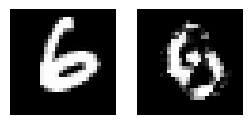

epoch 80
 gen : 3956.96851	 dis : 53.58784


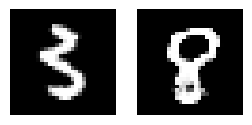

epoch 81
 gen : 3966.99460	 dis : 52.75327


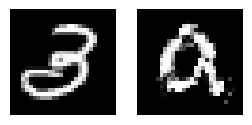

epoch 82
 gen : 4001.48721	 dis : 51.20919


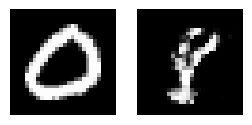

epoch 83
 gen : 4073.87513	 dis : 50.97354


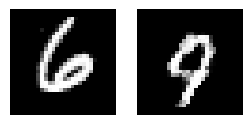

epoch 84
 gen : 4097.02009	 dis : 51.03173


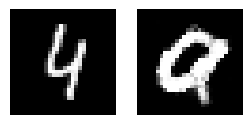

epoch 85
 gen : 4119.31477	 dis : 50.55296


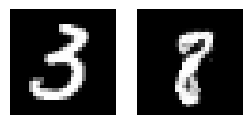

epoch 86
 gen : 4138.61543	 dis : 50.51848


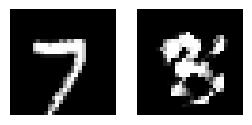

epoch 87
 gen : 4167.21576	 dis : 50.80610


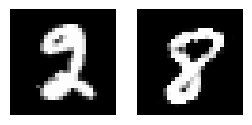

epoch 88
 gen : 4197.23833	 dis : 50.31476


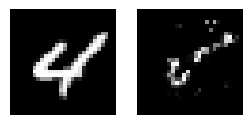

epoch 89
 gen : 4244.52537	 dis : 49.80541


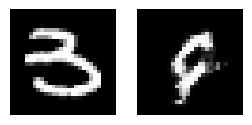

epoch 90
 gen : 4250.18598	 dis : 48.90428


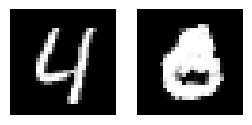

epoch 91
 gen : 4276.60918	 dis : 48.74411


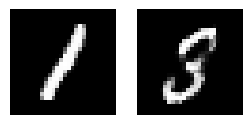

epoch 92
 gen : 4278.49091	 dis : 48.63800


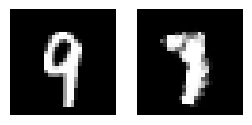

epoch 93
 gen : 4339.29388	 dis : 46.83560


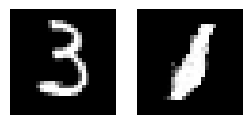

epoch 94
 gen : 4346.69679	 dis : 45.65935


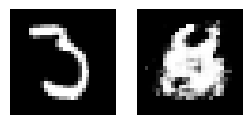

epoch 95
 gen : 4364.22874	 dis : 44.92510


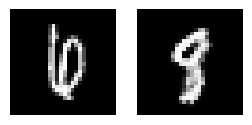

epoch 96
 gen : 4398.23221	 dis : 43.97039


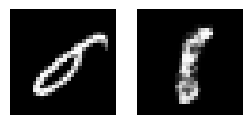

epoch 97
 gen : 4452.58454	 dis : 44.37432


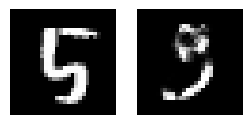

epoch 98
 gen : 4455.60669	 dis : 40.89116


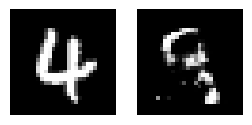

epoch 99
 gen : 4507.42547	 dis : 42.69488


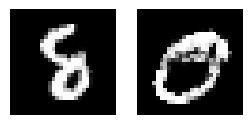

epoch 100
 gen : 4511.72638	 dis : 42.15984


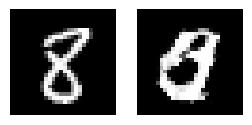

epoch 101
 gen : 4531.98802	 dis : 41.36486


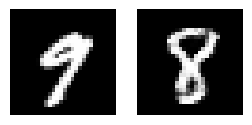

epoch 102
 gen : 4555.68375	 dis : 40.40326


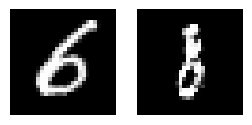

epoch 103
 gen : 4608.75861	 dis : 39.29029


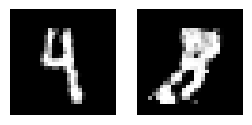

epoch 104
 gen : 4622.65069	 dis : 40.91729


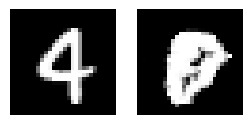

epoch 105
 gen : 4629.77172	 dis : 39.34552


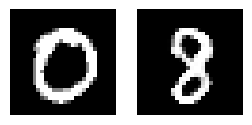

epoch 106
 gen : 4660.37688	 dis : 38.79008


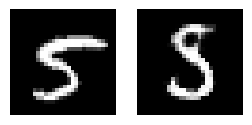

epoch 107
 gen : 4696.60442	 dis : 38.89129


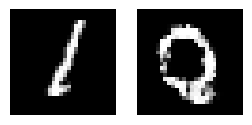

epoch 108
 gen : 4722.04970	 dis : 37.93621


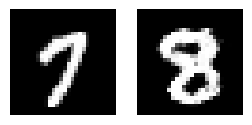

epoch 109
 gen : 4733.29818	 dis : 37.29918


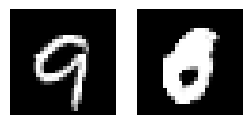

epoch 110
 gen : 4756.61406	 dis : 36.96065


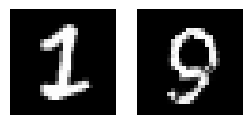

epoch 111
 gen : 4765.48511	 dis : 36.80386


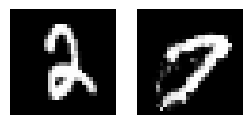

epoch 112
 gen : 4781.01660	 dis : 37.92646


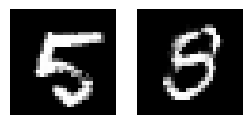

epoch 113
 gen : 4804.50858	 dis : 36.89158


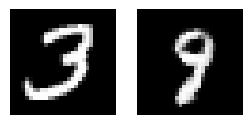

epoch 114
 gen : 4825.10743	 dis : 37.76705


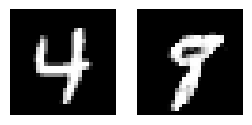

epoch 115
 gen : 4825.77087	 dis : 36.63267


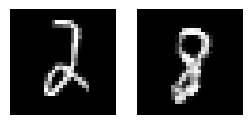

epoch 116
 gen : 4873.75515	 dis : 34.84820


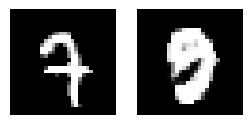

epoch 117
 gen : 4893.16795	 dis : 34.01960


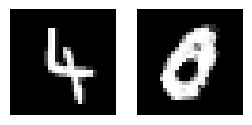

epoch 118
 gen : 4924.33012	 dis : 35.76024


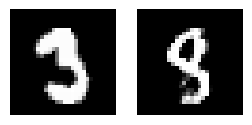

epoch 119
 gen : 4904.83334	 dis : 34.23977


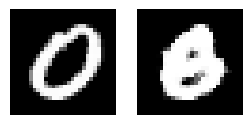

epoch 120
 gen : 4968.34724	 dis : 34.51711


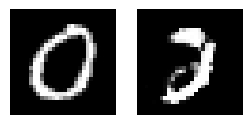

epoch 121
 gen : 4952.92852	 dis : 35.79040


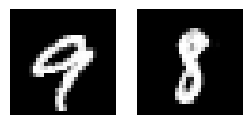

epoch 122
 gen : 4974.57981	 dis : 34.07631


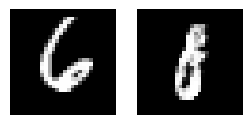

epoch 123
 gen : 4991.47758	 dis : 32.43878


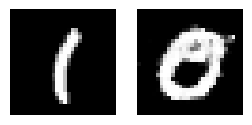

epoch 124
 gen : 5026.09167	 dis : 31.71230


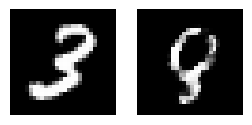

epoch 125
 gen : 5040.40812	 dis : 30.99493


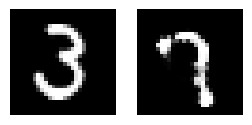

epoch 126
 gen : 5051.20812	 dis : 32.84316


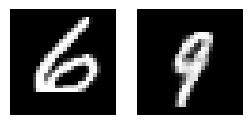

epoch 127
 gen : 5067.08617	 dis : 32.04287


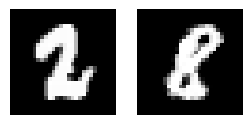

epoch 128
 gen : 5073.01894	 dis : 31.65534


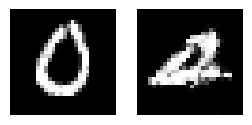

epoch 129
 gen : 5111.47661	 dis : 32.88159


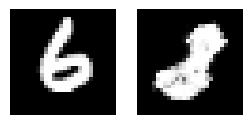

epoch 130
 gen : 5108.73649	 dis : 31.67906


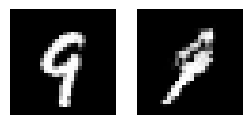

epoch 131
 gen : 5137.94201	 dis : 31.51406


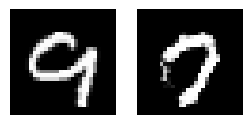

epoch 132
 gen : 5145.21732	 dis : 31.73159


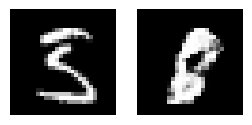

epoch 133
 gen : 5141.21291	 dis : 30.83452


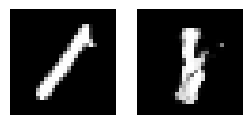

epoch 134
 gen : 5148.12358	 dis : 30.27679


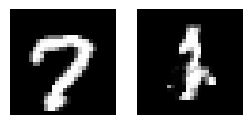

epoch 135
 gen : 5186.09531	 dis : 31.12138


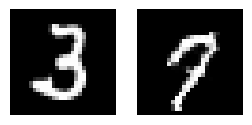

epoch 136
 gen : 5190.24655	 dis : 31.35696


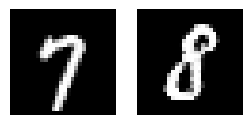

epoch 137
 gen : 5187.44801	 dis : 29.57289


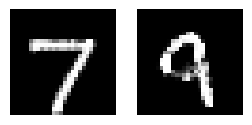

epoch 138
 gen : 5199.56524	 dis : 31.06010


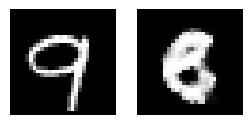

epoch 139
 gen : 5211.47517	 dis : 30.46720


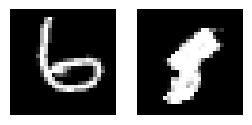

epoch 140
 gen : 5224.06396	 dis : 27.78293


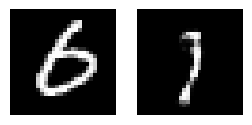

epoch 141
 gen : 5245.20108	 dis : 29.50994


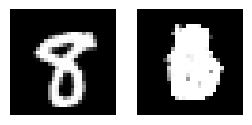

epoch 142
 gen : 5266.77884	 dis : 30.18963


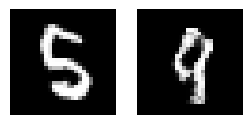

epoch 143
 gen : 5252.63385	 dis : 30.02377


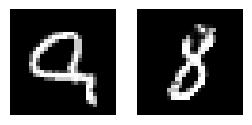

epoch 144
 gen : 5253.58773	 dis : 30.18023


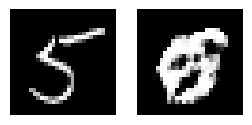

epoch 145
 gen : 5273.90541	 dis : 29.40938


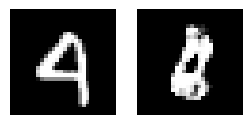

epoch 146
 gen : 5278.15694	 dis : 28.83803


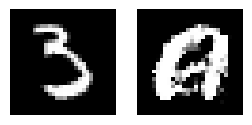

epoch 147
 gen : 5307.02681	 dis : 29.69306


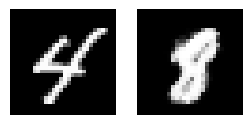

epoch 148
 gen : 5288.52139	 dis : 30.11628


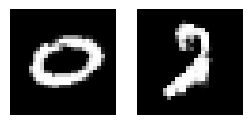

epoch 149
 gen : 5274.60064	 dis : 30.23704


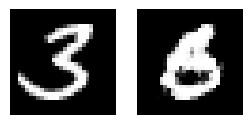

epoch 150
 gen : 5304.55911	 dis : 28.87194


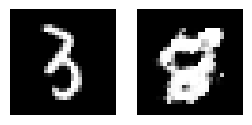

In [ ]:
gen = Generator(LATENT_SIZE)
dis = Discriminator()
if torch.cuda.is_available():
    gen = gen.cuda()
    dis = dis.cuda()

gen_parameters = filter(lambda p: p.requires_grad, gen.parameters())
num_params = sum([np.prod(p.size()) for p in gen_parameters])
print("number of parameters(generator) : {}".format(num_params))
dis_parameters = filter(lambda p: p.requires_grad, dis.parameters())
num_params = sum([np.prod(p.size()) for p in dis_parameters])
print("number of parameters(discriminator) : {}".format(num_params))

optimizer_G = Adam(gen.parameters(),lr=LEARNING_RATE)
optimizer_D = Adam(dis.parameters(),lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    tot_gen_loss = 0
    tot_dis_loss = 0
    cnt = 0
    for img,label in train_loader:
        onehot_label = one_hot(label)
        if torch.cuda.is_available():
            img = img.cuda()
            onehot_label = onehot_label.cuda()

        if cnt % LEARNING_RATIO == 0:
            optimizer_D.zero_grad()
            real = dis(img,onehot_label)
            img_ = gen(onehot_label)
            fake = dis(img_,onehot_label)
            dis_loss = -torch.mean(torch.log(real+EPS)+torch.log(1+EPS-fake))
            dis_loss.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        img_ = gen(onehot_label)
        fake = dis(img_,onehot_label)
        gen_loss = -torch.mean(torch.log(fake+EPS))
        gen_loss.backward()
        optimizer_G.step()
        tot_dis_loss +=dis_loss.item()
        tot_gen_loss +=gen_loss.item()
        cnt+=1

    print("epoch {}\n gen : {:.5f}\t dis : {:.5f}".format(epoch+1,tot_gen_loss,tot_dis_loss))
    img, label = next(iter(test_loader))
    onehot_label = one_hot(label)
    if torch.cuda.is_available():
        onehot_label = onehot_label.cuda()
    img_ = gen(onehot_label)
    fig = plt.figure(figsize=(3,3))
    fig.add_subplot(1,2,1)
    plt.imshow(img[0].squeeze().numpy(),cmap='gray')
    plt.axis('off')
    img_out = img_[0].squeeze().cpu().detach().numpy()
    fig.add_subplot(1,2,2)
    plt.imshow(img_out,cmap='gray')
    plt.axis('off')
    plt.show()